In [1]:
from pdc_project.settings import *
from pdc_project.encoder import *
from pdc_project.helper import *
from pdc_project.transmitter import *
from pdc_project.modulation import *

import numpy as np
import pylab as pl
import scipy.signal.signaltools as sigtool
import scipy.signal as signal
from numpy.random import sample
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

# Helper

In [2]:
A_n = 12000       #noise peak amplitude
N_prntbits = 150  #number of bits to print in plots

In [3]:
def plot_data(y, t, m):
    #view the data in time and frequency domain
    #calculate the frequency domain for viewing purposes
    N_FFT = float(len(y))
    f = np.arange(0,Fs/2,Fs/N_FFT)
    w = np.hanning(len(y))
    y_f = np.fft.fft(np.multiply(y,w))
    y_f = 10*np.log10(np.abs(y_f[0:int(N_FFT/2)]/N_FFT))
    
    pl.subplot(2,2,1)
    pl.plot(t[0:int(Fs*N_prntbits/Fbit)],m[0:int(Fs*N_prntbits/Fbit)])
    pl.xlabel('Time (s)')
    pl.ylabel('Frequency (Hz)')
    pl.title('Original VCO output versus time')
    pl.grid(True)
    
    pl.subplot(2,2,2)
    pl.plot(t[0:int(Fs*N_prntbits/Fbit)],m[0:int(Fs*N_prntbits/Fbit)])
    pl.xlabel('Time (s)')
    pl.ylabel('Amplitude (V)')
    pl.title('Amplitude of carrier versus time')
    pl.grid(True)
    
    pl.subplot(2,2,3)
    pl.plot(t[0:int(Fs*N_prntbits/Fbit)],y[0:int(Fs*N_prntbits/Fbit)])
    pl.xlabel('Time (s)')
    pl.ylabel('Amplitude (V)')
    pl.title('Amplitude of carrier versus time')
    pl.grid(True)
    
    pl.subplot(2,2,4)
    pl.plot(f[0:int((Fc+Fdev*2)*N_FFT/Fs)],y_f[0:int((Fc+Fdev*2)*N_FFT/Fs)])
    pl.xlabel('Frequency (Hz)')
    pl.ylabel('Amplitude (dB)')
    pl.title('Spectrum')
    pl.grid(True)
    
    pl.tight_layout()
    pl.show()

# Transmitter

First, we encode the data and create the waveform.

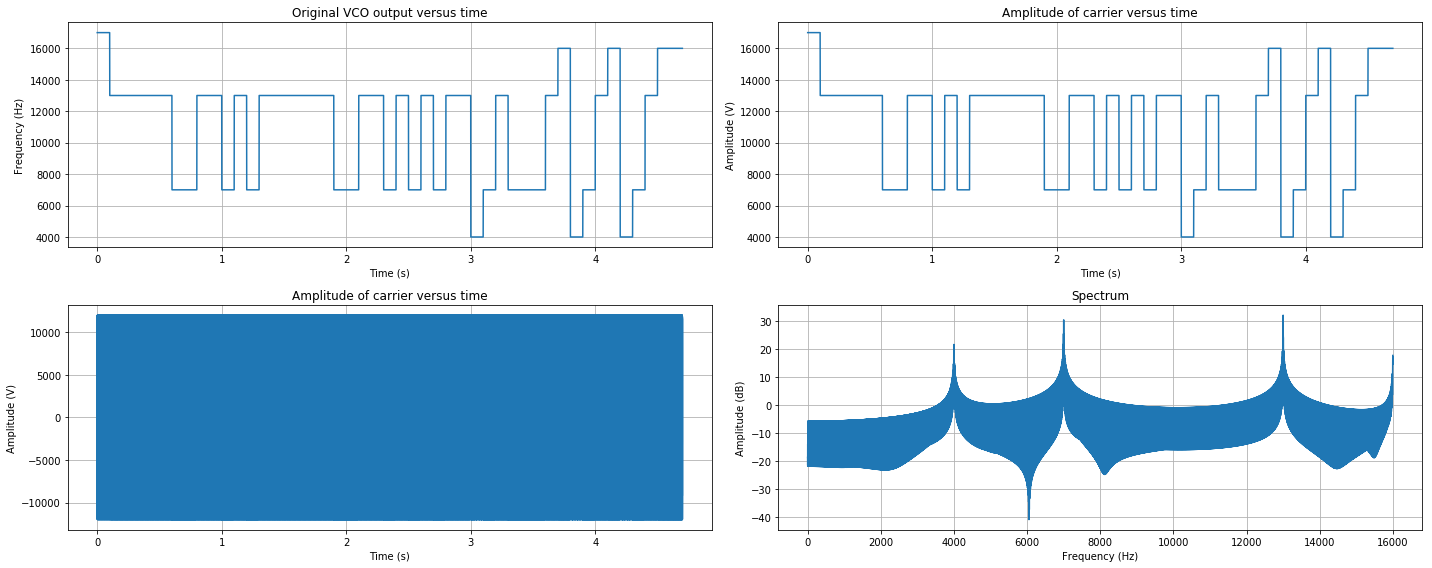

In [4]:
message = "Hello"
data = encode_data(message)
sig, t, sig_freq = prepare_signal(data, debug=True)
plot_data(sig, t, sig_freq)

# Channel

We add some random noise to simulate the channel adn add some delay.

SNR = -6.011302dB
119585


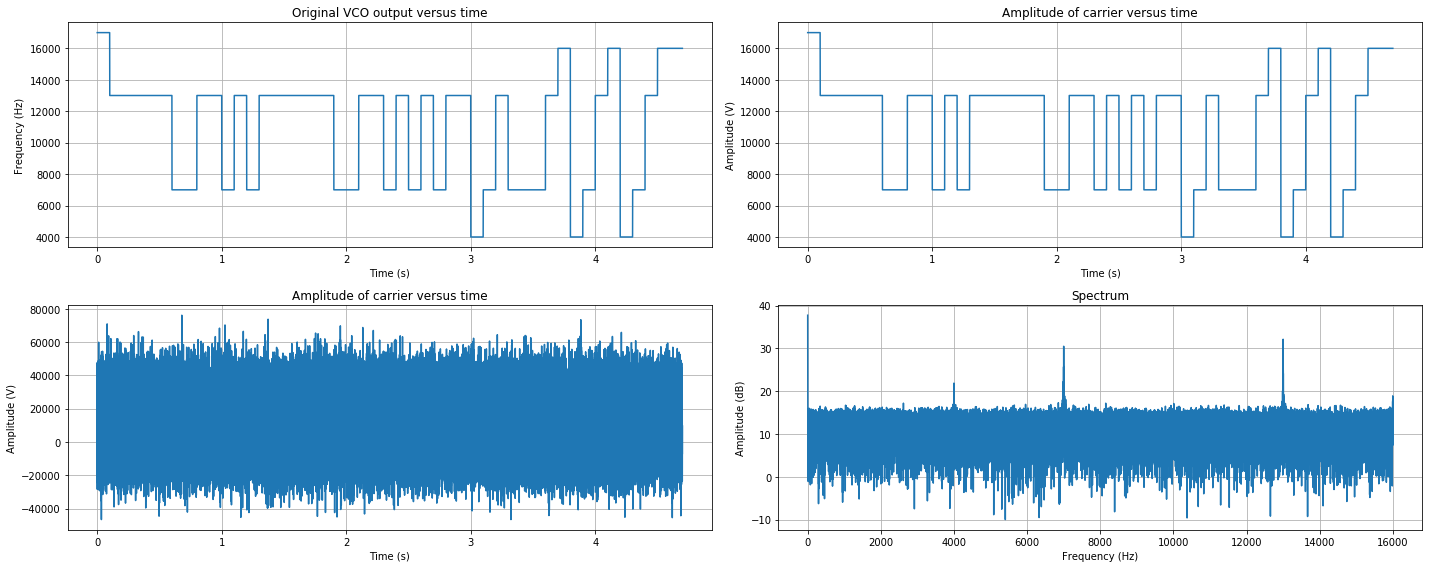

In [52]:
noise = (np.random.randn(len(sig))+1)*A_n
snr = 10*np.log10(np.mean(np.square(sig)) / np.mean(np.square(noise)))
print("SNR = %fdB" % snr)
delay = np.random.randint(1000,len(noise/2))
print(delay)
y = np.concatenate([noise[:delay],np.add(sig,noise)])
plot_data(y[delay:], t, sig_freq)

# Receiver

In [53]:
unprocessed_chunks = []
unprocessed_bits = []

RECEIVED_START = False
last_chunk = np.empty(shape=(0))
for data in chunks(list(y), CHUNK): 
    
    if not RECEIVED_START:
        fft_sample = fft(data) 
        if content_at_freq(fft_sample, START_FREQ, Fs, Fbit) > START_FREQ_THRESHOLD: 
            RECEIVED_START = True
            unprocessed_chunks.append(last_chunk)
            print("Transmission!")
    
    if RECEIVED_START:
        unprocessed_chunks.append(data)
    
    last_chunk = data
       
########

start_signal = get_start_signal()
print(len(start_signal))
sync_signal = get_sync_signal()
SYNCED = False

duration = int(Fs/Fbit)
chunks_buffer = np.empty(shape=(0))
for data in unprocessed_chunks:
    chunks_buffer = np.concatenate([chunks_buffer, data])
    
    if not SYNCED and len(chunks_buffer) > len(start_signal) + len(sync_signal) + RESEARCH_WINDOW :
        index = synchronise_signal(chunks_buffer)
        if index+len(sync_signal) < len(chunks_buffer):
            chunks_buffer = chunks_buffer[index + len(sync_signal):]
            SYNCED = True
    
    if SYNCED and len(chunks_buffer) > duration:
        rest = len(chunks_buffer) % duration
        
        for chunk in chunks(chunks_buffer[:-rest], duration) :
            bits = fsk_demodulation(chunk, 2, Fs, Fc, Fdev)
            unprocessed_bits = unprocessed_bits + bits
            
        chunks_buffer = chunks_buffer[-rest:]

bits_buffer = []
string = ""
for bit in unprocessed_bits:
    bits_buffer.append(bit)
         
    if len(bits_buffer) == 8*FORWARD_ENCODING_LENGTH:
        bits = [bit if bit != -1 else 0 for bit in bits_buffer]
        message = decode_data(bits)
        string += message
        bits_buffer = []
        
string        

Transmission!
4410


'hello'

-----------